In [ ]:
%%capture

!pip install bertopic
!pip install octis
!pip uninstall gensim -y
!pip install git+https://github.com/RaRe-Technologies/gensim.git@refs/pull/3172/merge

from google.colab import drive
drive.mount("/content/drive", force_remount=True)
import os
os.chdir("/content/drive/My Drive/Evaluation/")

from octis.dataset.dataset import Dataset
from data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string

from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import nltk
from nltk import bigrams
from nltk import trigrams
from nltk import ngrams
import itertools
import pandas as pd
import math
import itertools
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import umap
import hdbscan
from bertopic import BERTopic
import tensorflow_hub
from sentence_transformers import SentenceTransformer

#Datasets for DTM

**UN_dtm dataset**

In [ ]:
%%time
dataloader = DataLoader(dataset="trump_dtm").prepare_docs(save="trump_dtm.txt").preprocess_octis(output_folder="trump_dtm")

created vocab
53637
words filtering done
CPU times: user 4min 6s, sys: 3.31 s, total: 4min 9s
Wall time: 4min 56s


In [ ]:
%%capture

# Prepare data
#dataset, custom = "trump_dtm", True
dataset, custom = "trump_dtm", True
data_loader = DataLoader(dataset)
_, timestamps = data_loader.load_docs()
data = data_loader.load_octis(custom)
data = [" ".join(words) for words in data.get_corpus()]

# Match indices
import os
os.listdir(f"./{dataset}")
with open(f"./{dataset}/indexes.txt") as f:
    indices = f.readlines()
    
indices = [int(index.split("\n")[0]) for index in indices]
#timestamps = [timestamp for index, timestamp in enumerate(timestamps) if index in indices]
Timestamps = [timestamp for index, timestamp in enumerate(timestamps) if index in indices]
len(data), len(timestamps)

**Trump_dtm dataset**

In [ ]:
import re
import pandas as pd
from datetime import datetime

# Load data
trump = pd.read_csv('https://drive.google.com/uc?export=download&id=1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6')

# Filter
trump.text = trump.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
trump.text = trump.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
trump.text = trump.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.text).split()), 1)
trump = trump.loc[(trump.isRetweet == "f") & (trump.text != ""), :]
Timestamps = trump.date.to_list()
timestamps = [Timestamps[i][:4] for i in range(len(Timestamps))]
tweets = trump.text.to_list()
data = tweets

#Functions for our model and evaluation

In [ ]:
####### c-TF-IDF #######
def c_tf_idf(documents, m, ngram_range=(1, 1)):
  count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
  t = count.transform(documents).toarray()
  w = t.sum(axis=1)
  tf = np.divide(t.T, w)
  sum_t = t.sum(axis=0)
  idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
  tf_idf = np.multiply(tf, idf)
  return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
  '''
  This function allows us to extract the top n words in a topic
  '''
  words = count.get_feature_names()
  labels = list(docs_per_topic.Topic)
  tf_idf_transposed = tf_idf.T
  indices = tf_idf_transposed.argsort()[:, -n:]
  top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
  return top_n_words

def extract_topic_sizes(df):
  topic_sizes = (df.groupby(['Topic'])
                      .Doc
                      .count()
                      .reset_index()
                      .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                      .sort_values("Size", ascending=False))
  return topic_sizes





####################################################################################
######################### Functions for the evaluation #############################
####################################################################################


#@@@@@@@@@@@@@@@@@@@@@@@@@ Functions for Topic Coherence #@@@@@@@@@@@@@@@@@@@@@@@@@@

def word_proba(data): # data is a list of words
    '''
    This function returns the probability of every word of a list based on their frequency in that list.
    data : is a list of words, rerpresenting the list of words of a text that has been pre-processed.
    '''
    counts = dict()
    words = data
    k = 0

    for word in words:
        if word in counts:
            counts[word] += 1
            k+=1
        else:
            counts[word] = 1
            k+=1

    for word in counts :
      counts[word] = counts[word]/k

    return counts


def N_word_proba(data, N): 
    '''
    Parameters 
    ----------
    data : is a list of words, typically the list of the top-K words of a topic
    N    : is the size of the "window" we consider for quantifying the co-occurrence of words 

    This function returns a dictionnary containing the probability of each "window of words" of a text (represented by data).
    '''
    counts = dict()
    N_grams = list(ngrams(data, N))
    k = 0

    for uplet in N_grams :
        if uplet in counts:
            counts[uplet] += 1
            k+=1
        else:
            counts[uplet] = 1
            k+=1

    for uplet in counts :
      counts[uplet] = counts[uplet]/k

    ###############
    for k in counts :
      permutations = list(itertools.permutations(k))
      permutations.remove(k)
      for permu in permutations :
        if permu in counts :
          counts[k] += counts[permu]

    for k in counts :
      permutations = list(itertools.permutations(k))
      permutations.remove(k)
      for permu in permutations :
        if permu in counts :
          Min = min(counts[k], counts[permu])
          counts[k] = Min
          counts[permu] = Min
    ##############

    return counts



#@@@@@@@@@@@@@@@@@@@@@@@@@ Functions for Topic Diversity #@@@@@@@@@@@@@@@@@@@@@@@@@@

def proportion_unique_words(topics, topk=25):
    """
    This function computes the proportion of unique words, this is how we quantify topic diversity !

    N.B. : the proportion of unique words is a Topic Diversity metric !!!!!!

    Parameters
    ----------
    topics: a list of lists of words
    topk: top k words on which the topic diversity will be computed
    """
    if topk > len(topics[0]):
        raise Exception('Words in topics are less than '+str(topk))
    else:
        unique_words = set()
        for topic in topics:
            unique_words = unique_words.union(set(topic[:topk]))
        puw = len(unique_words) / (topk * len(topics))
        return puw

**Loading our document embedding model**

In [ ]:
# We load our document embedder model
embedding_model = tensorflow_hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # USE is our document embedding model !

# Evaluation + Visualization of topics

In [ ]:
#### THIS IS FOR TRUMP DTM dataset
DATAFRAME = pd.DataFrame(tweets, columns = ["Doc"])
#dataframe = pd.DataFrame(data, columns = ["Doc"])
DATAFRAME["timestamps"] = timestamps
timestamp = list(np.unique(DATAFRAME.timestamps.values))

average_npmi = 1.0307774823453852
topic_npmi =  [0.020623648067844825, 0.39104553892216215, 0.6191082953553783]
The overall average npmi value, at timestamp 2010, is  0.34359249411512843
The topic diversity (TD) value, at timestamp 2010, is  1.0
average_npmi = 0.6066914795574969
topic_npmi =  [-0.10792079001036306, 0.4470527679742696, -0.006944056652437207, -0.05614706319062079, -0.05569638266400566, 0.23073336225857588, 0.15561364184207815]
The overall average npmi value, at timestamp 2011, is  0.0866702113653567
The topic diversity (TD) value, at timestamp 2011, is  0.9571428571428572
average_npmi = 2.484383177823413
topic_npmi =  [-1.0, 0.38016611498679365, 0.29551019332278594, 0.5607838901218157, -0.13979801996136254, -1.0427605036431928, 0.32573497990752115, -0.213307244744895, 0.22696162233270156, 0.13967891203639787, 0.12559480442201812, 0.32617521705728075, 0.39970613988213816, -0.10905804376349407, -0.07496120466027272, -0.06408958732210113, -0.11601261272071842, 0.11050376075

ZeroDivisionError: ignored

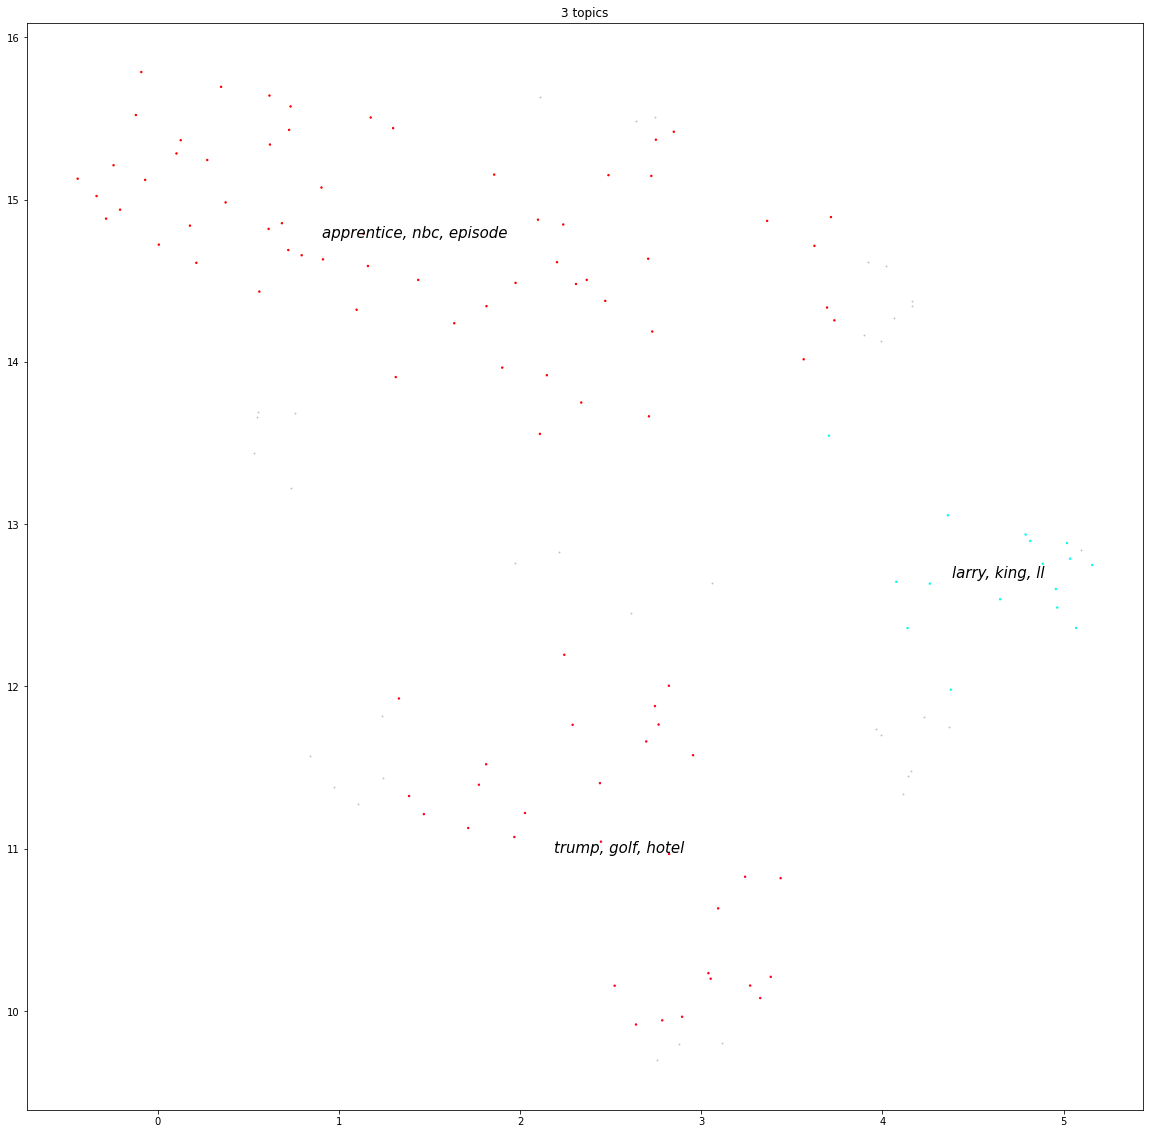

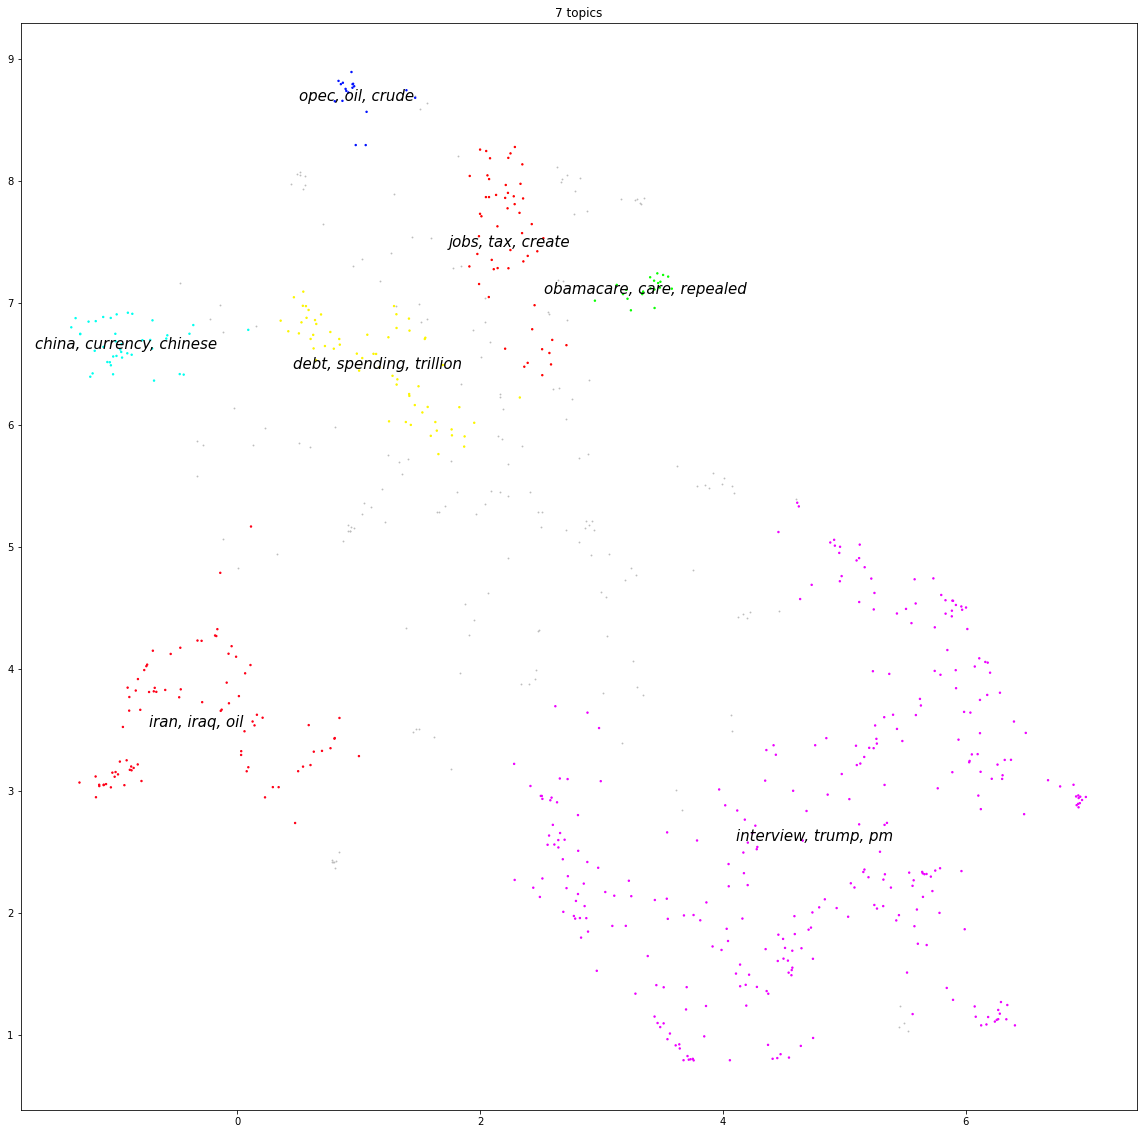

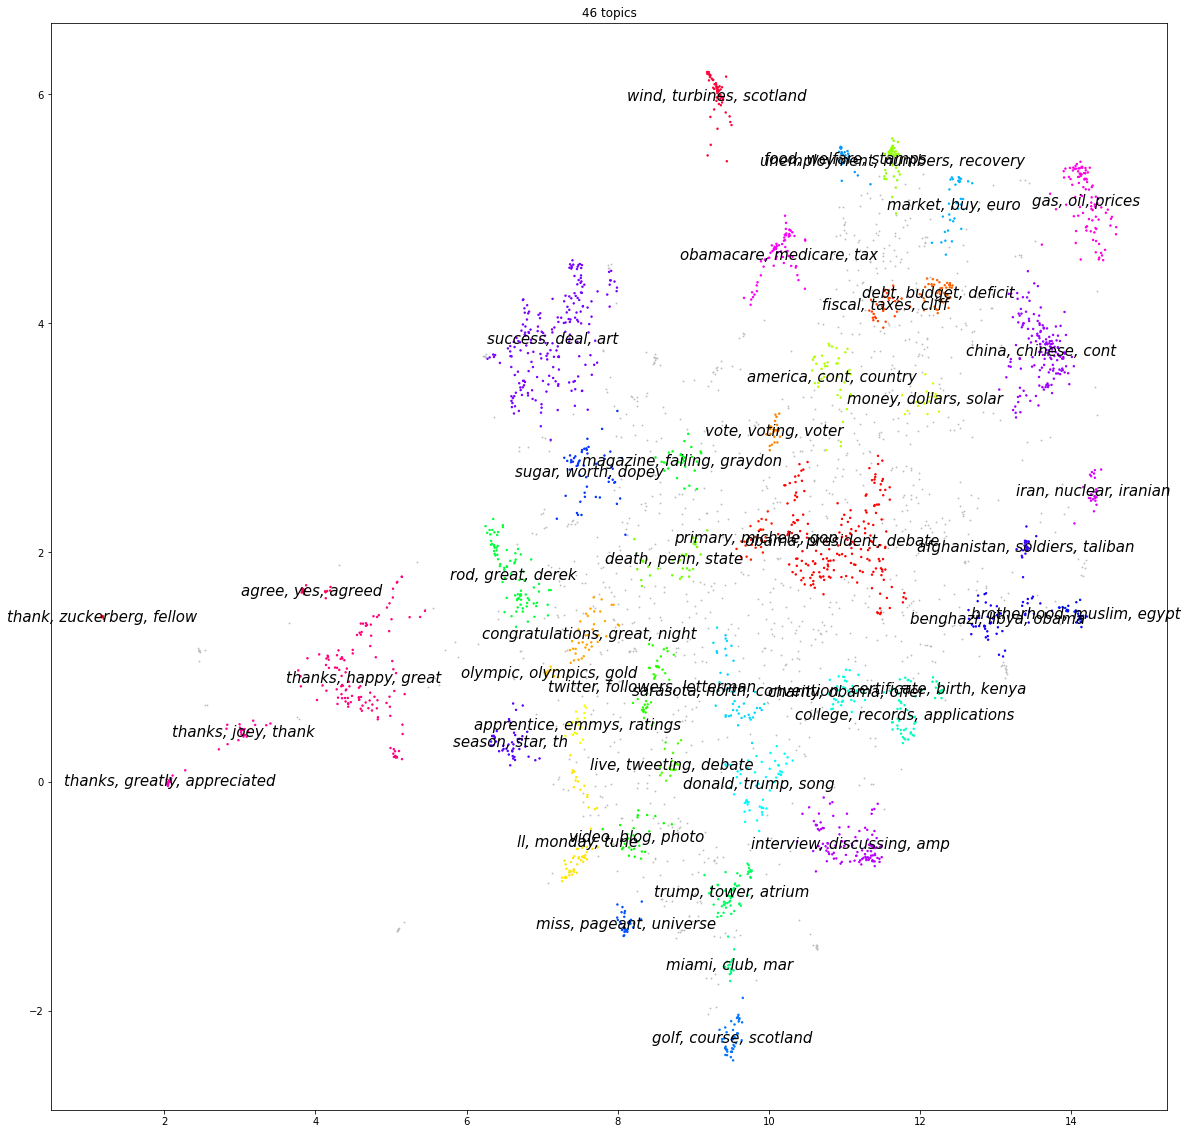

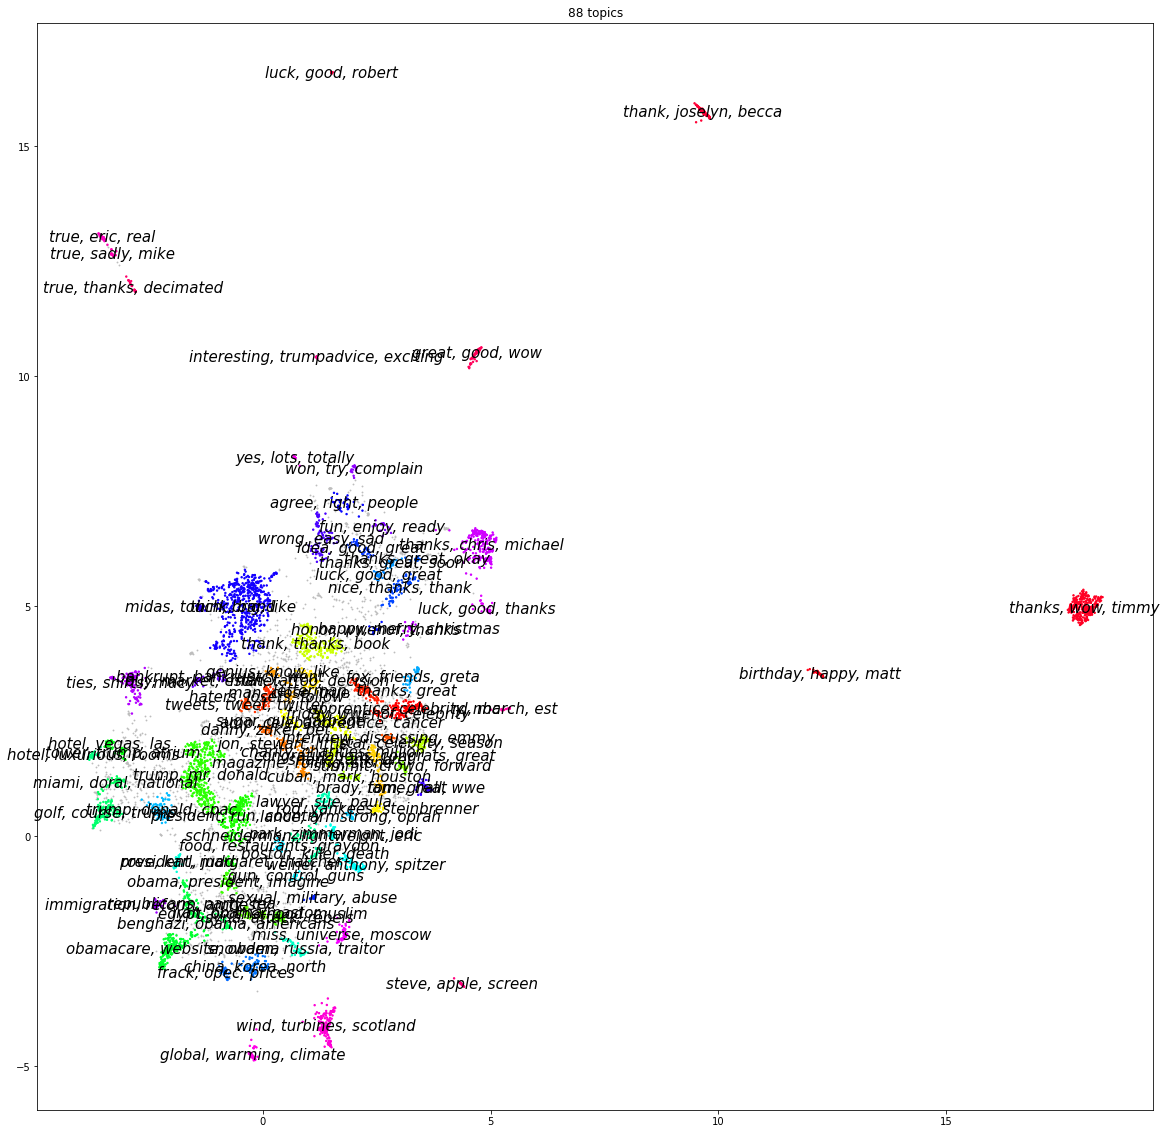

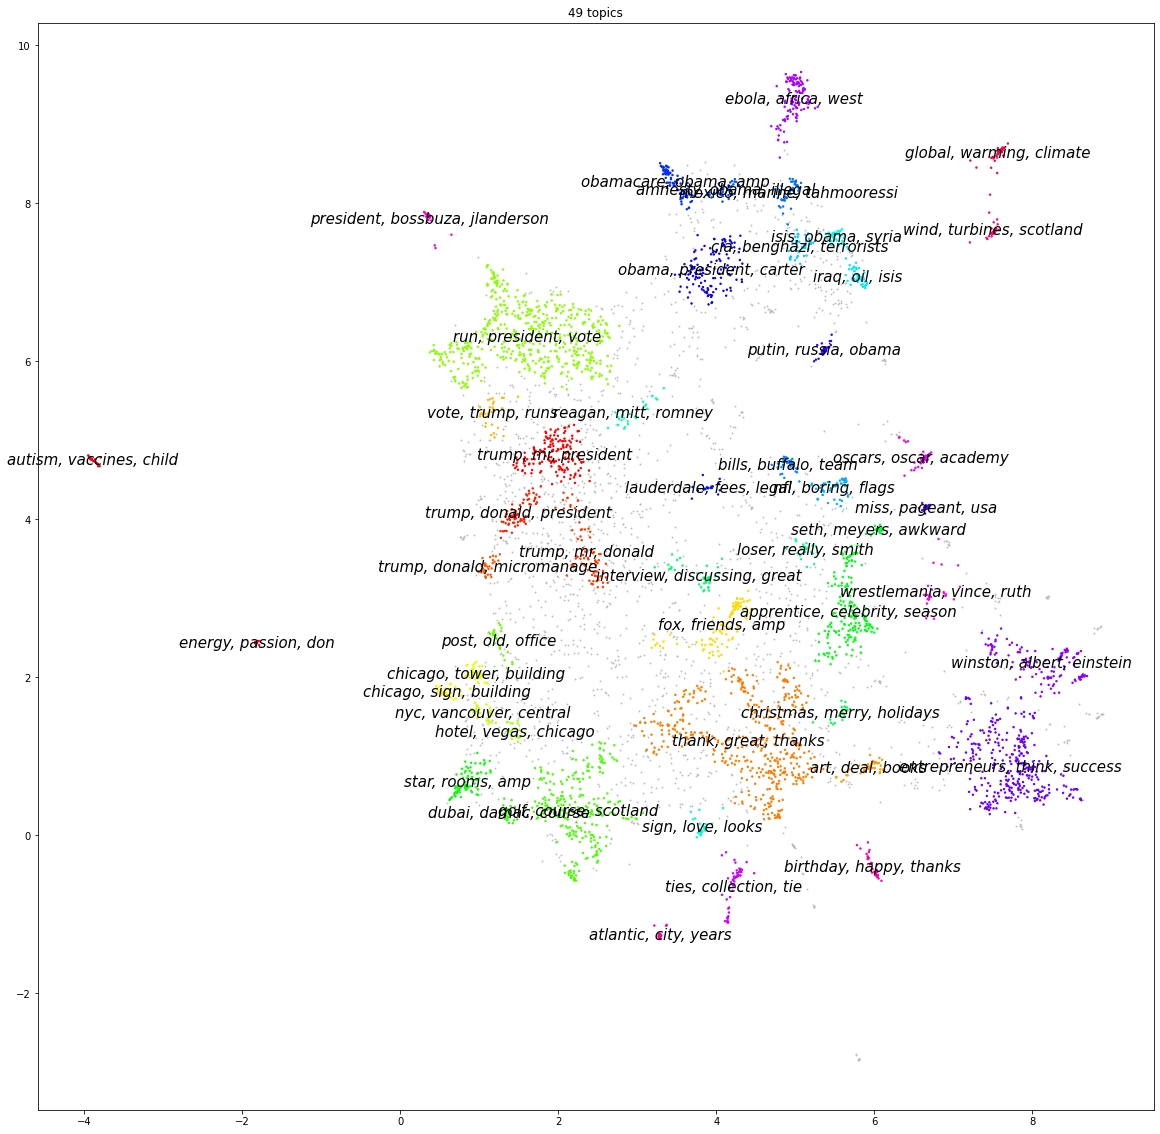

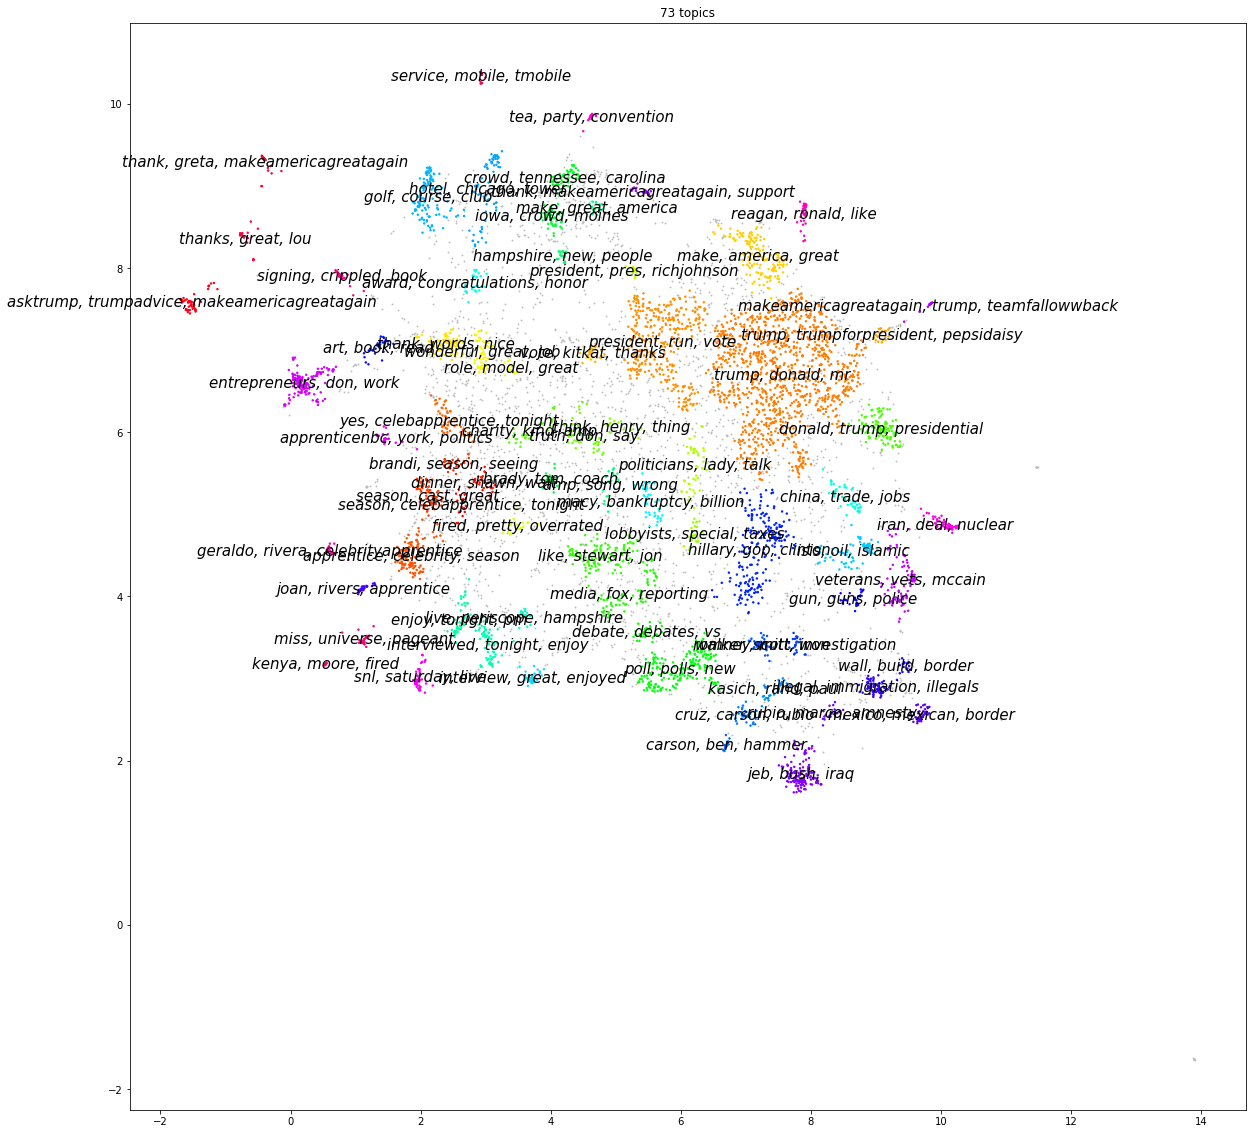

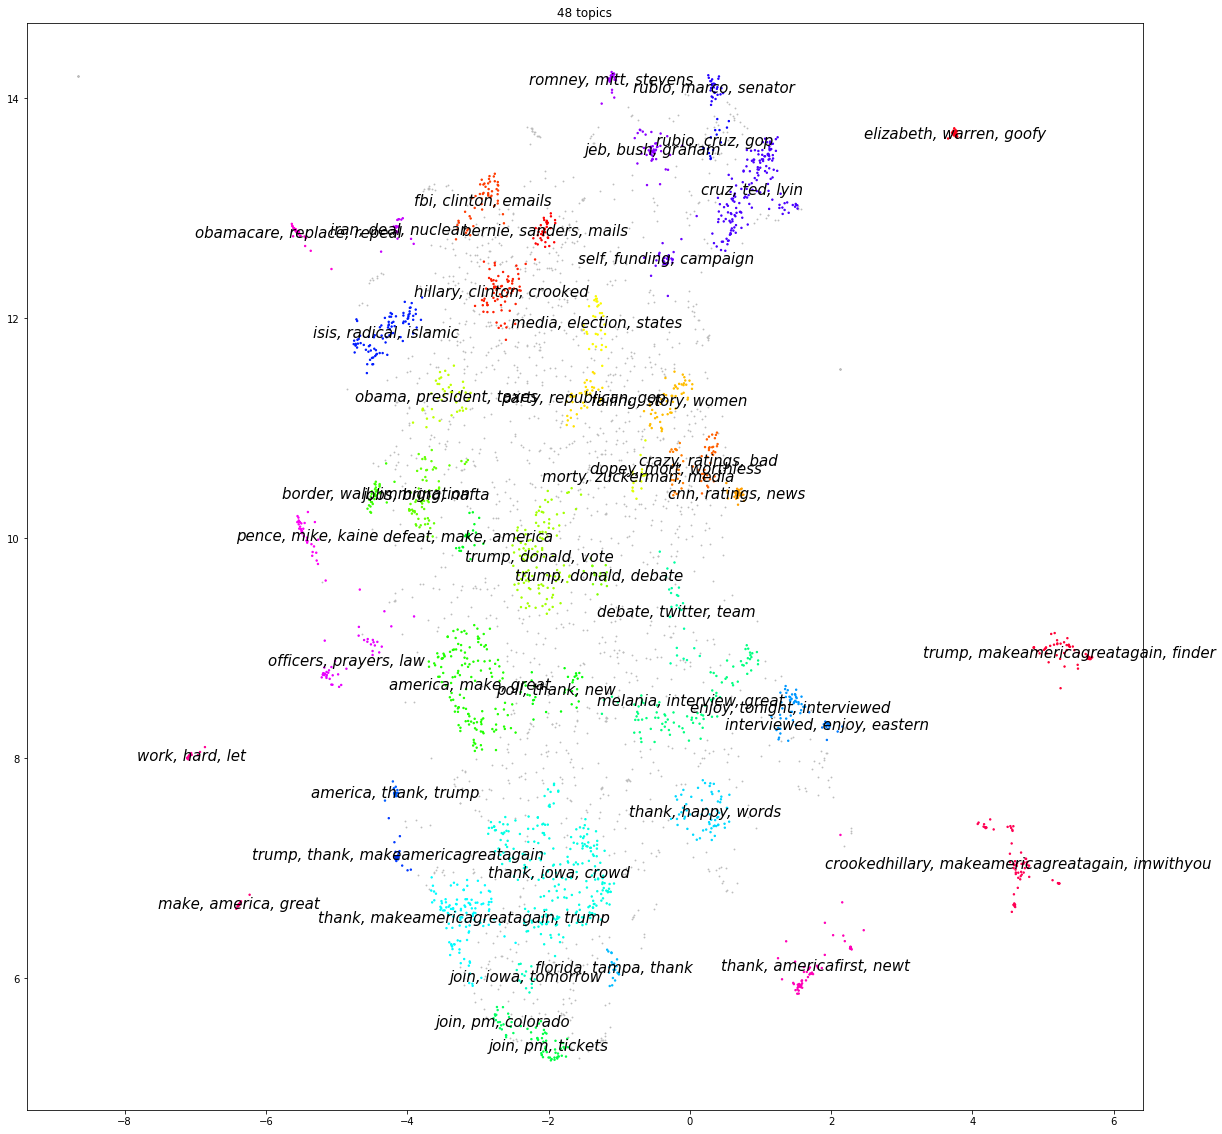

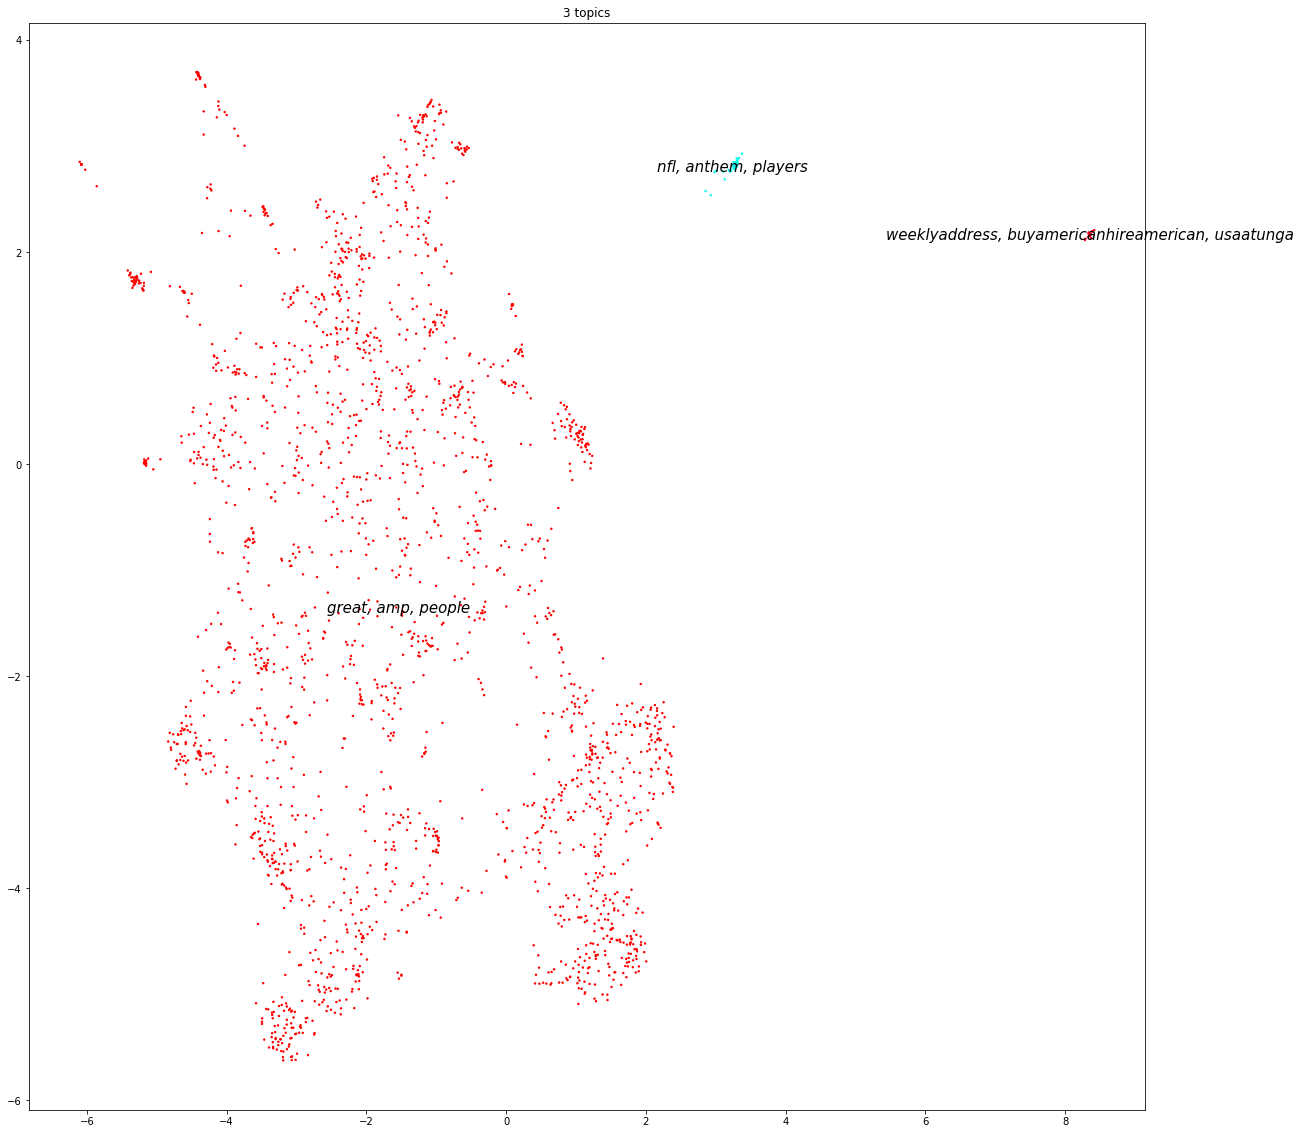

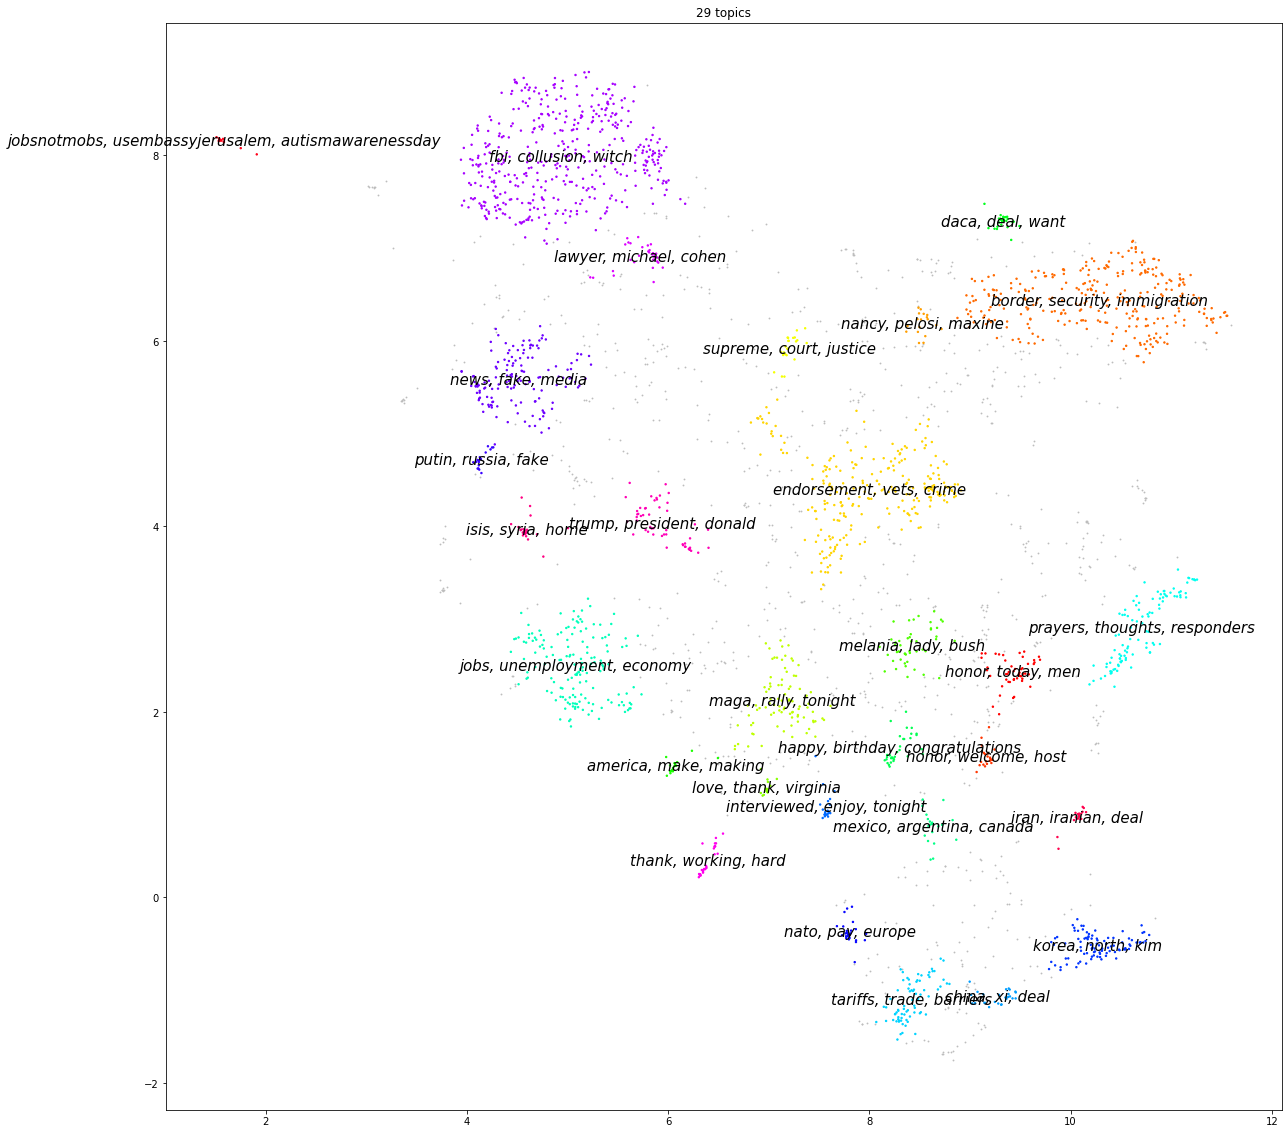

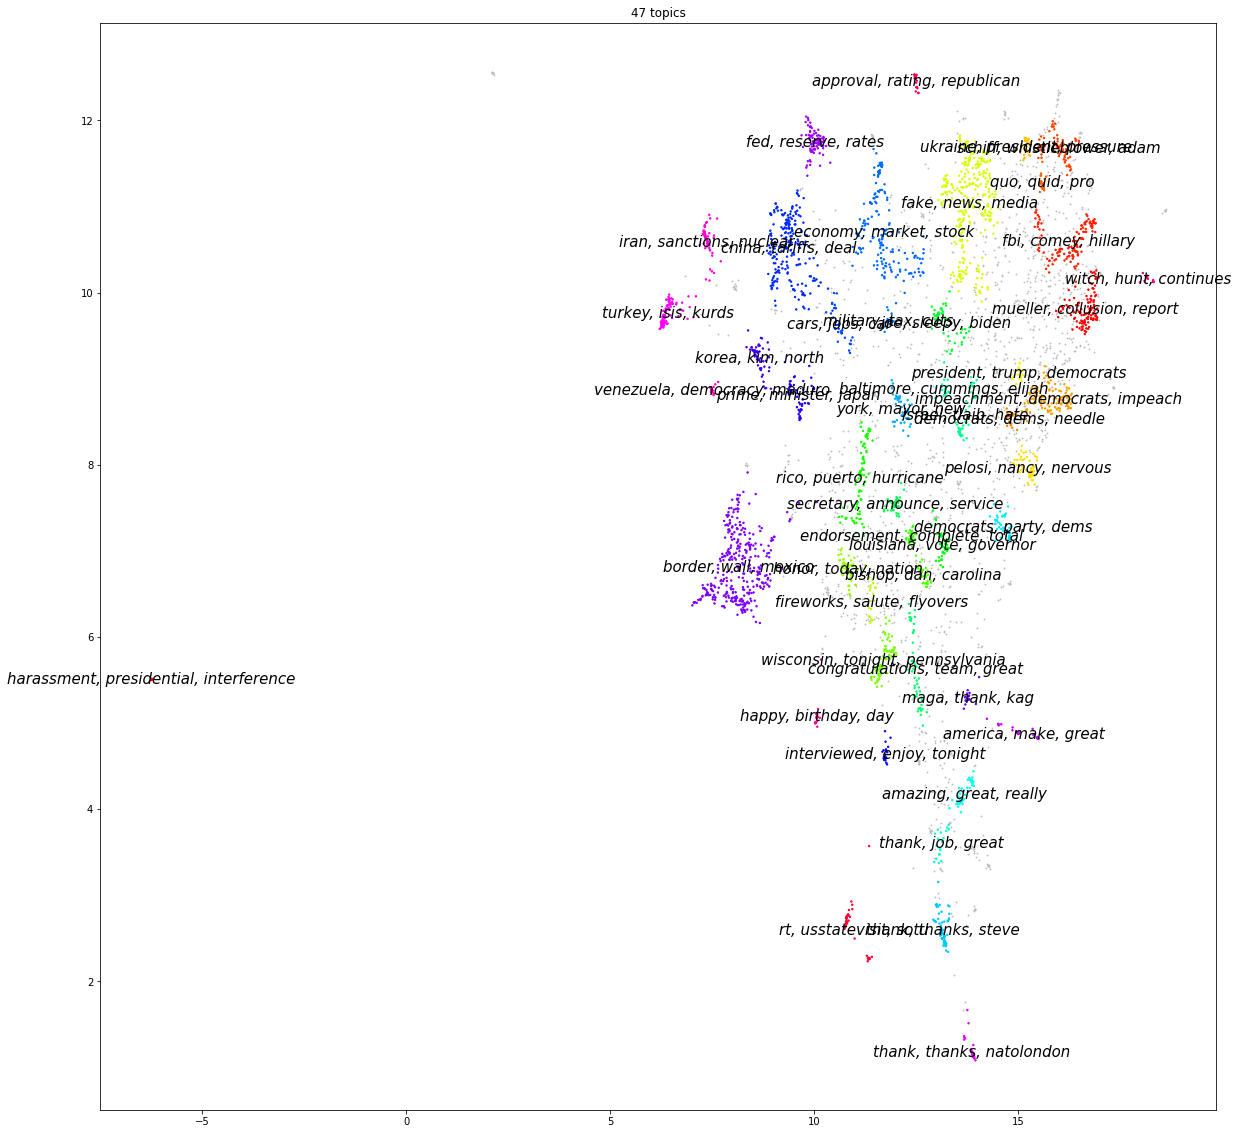

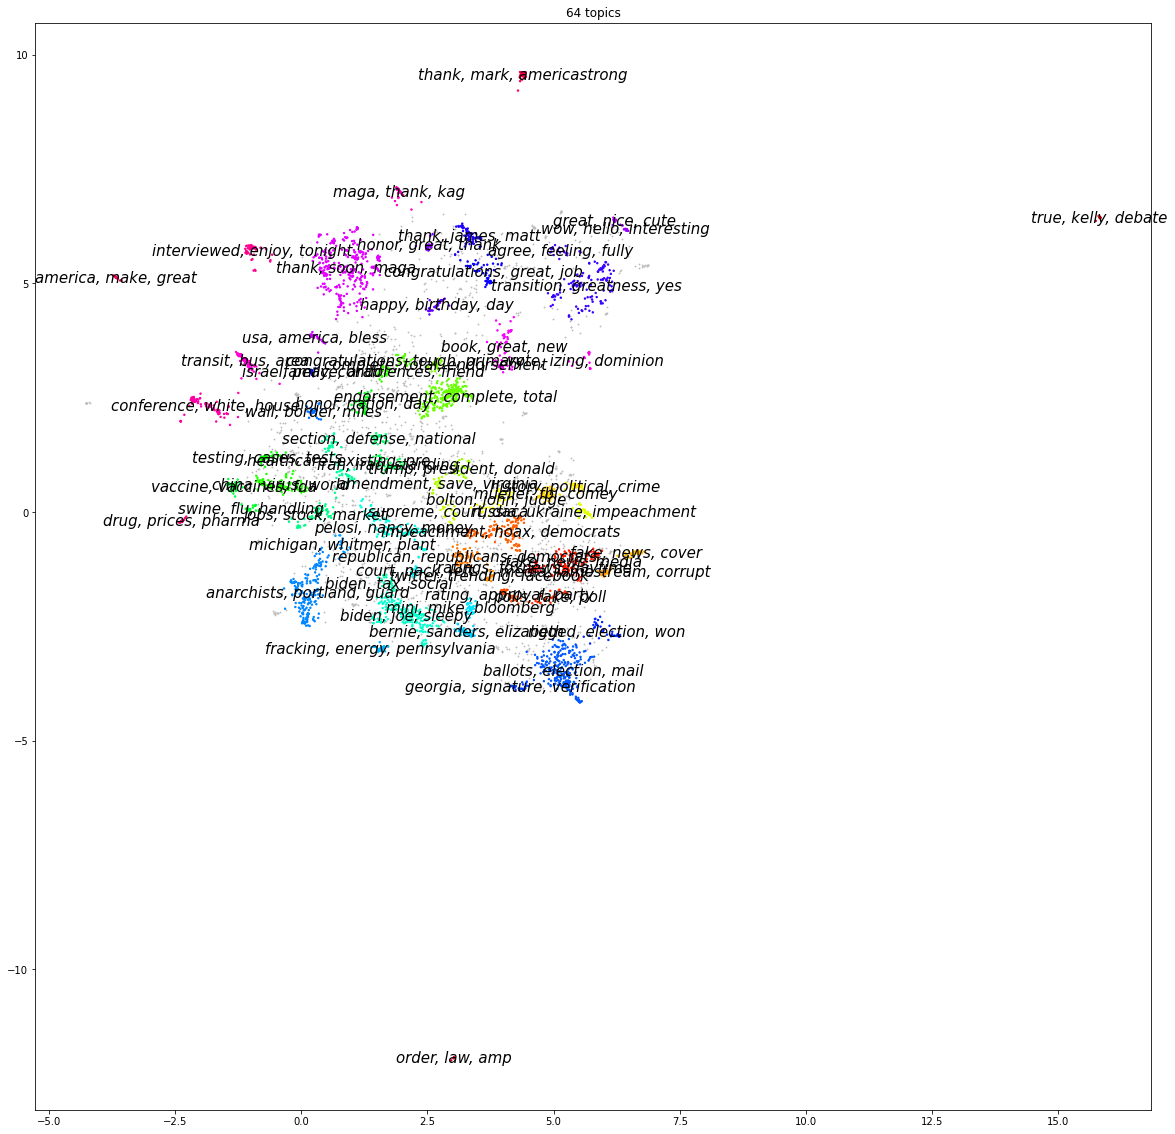

In [ ]:
evaluation = pd.DataFrame(columns = ["timestamp", "TC", "TD"]) #dataframe containing all metrics values for all timestamps

#timestamp = np.unique(timestamps)

for t in timestamp : 

  dataframe = pd.DataFrame(tweets, columns = ["Doc"]) # THIS IS FOR Trump dtm dataset
  #dataframe = pd.DataFrame(data, columns = ["Doc"])
  dataframe["timestamps"] = timestamps
  DATA = dataframe[dataframe["timestamps"] == t].Doc.values

  ####### Embbed the documents #######
  embeddings = embedding_model(DATA)
  embeddings = np.array(embeddings)

  ####### UMAP (dimension) #######
  umap_args = {'n_neighbors': 15,'n_components': 2,'metric': 'cosine'}
  umap_model = umap.UMAP(**umap_args).fit(embeddings)
  umap_model = umap_model.fit(embeddings)
  umap_embeddings = umap_model.transform(embeddings)

  ####### HDBSCAN (clustering) #######
  hdbscan_args = {'min_cluster_size': 15, 'metric': 'euclidean', 'cluster_selection_method': 'eom'} #'min_cluster_size': 15 is the standard value in HDBSCAN
  cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_embeddings)
  #To look at the clusters found by the algorithm, we just need to run "cluster.labels_" or "np.unique(cluster.labels_)"

  # We create a dataframe for the visualization part
  result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
  result['labels'] = cluster.labels_
  result["text"] = DATA

  ########### c-TF-IDF #############
  '''
  Now, we are going to compute the c-TF-IDF value of each word. The function c-tf-idf has been implemented earlier in 
  the code. 
  We start by creating a dataframe "docs_df" to facilitate the computation of c-TF-IDF.
  '''
  docs_df = pd.DataFrame(DATA, columns=["Doc"])
  docs_df['Topic'] = cluster.labels_
  docs_df['Doc_ID'] = range(len(docs_df))
  docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})



  ################################################################################
  # We concatenate all documents from timestamp t into a single document we call overall_text
  docs_per_topic['overall'] = [0 for i in range(len(docs_per_topic))]
  overall_text = docs_per_topic.groupby(['overall'], as_index = False).agg({'Doc': ' '.join}) #contains all documents (concatenated) from timestamp t

  # We retrieve the list of words of the overall text (for the computation of npmi)
  text = overall_text.Doc.values[0]
  text_tokens = word_tokenize(text)

  ########## The following line of code takes 30 seconds to execute ! ##########
  list_of_words = [word for word in text_tokens if not word in stopwords.words('english')] #contains the list of words composing the text (without stopwords!)
  ################################################################################



  ####### c-TF-IDF #######
  tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(DATA))
  # N.B. : "tf-idf" contains the c-TF-IDF values. Hence, we have a single importance value for each word in a cluster *

  ####### Topic representation #######
  top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10) #n=20
  top_n_words_TD = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=25) # We will use this top_n_words_TD for computing Topic Diversity !

  topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

  ####### Plot #######
  '''
  In order to display the words along with the clusters (topics), we need to calculate the topic vectors.
  '''
  unique_labels = set(cluster.labels_)
  # Since topic -1 refers to outliers/noises, we need to remove the noise and work with the "real" topics 
  if -1 in unique_labels:
    unique_labels.remove(-1)

  topic_vectors = np.array([result[result["labels"]== label][["x","y"]].mean() for label in unique_labels])

  # We concatenate the three first words of each topic (for the plot)
  topics = [top_n_words[i][0][0]+", "+top_n_words[i][1][0]+", "+top_n_words[i][2][0] for i in range(len(topic_vectors))]



  # The code below takes around 6 min to execute !
  ################################################################################
  ################################################################################
  #### We create the list of topic words for the evaluation
  topic_words = [[top_n_words[i][j][0] for j in range(len(top_n_words[i]))] for i in unique_labels]
  topic_words_TD = [[top_n_words_TD[i][j][0] for j in range(len(top_n_words_TD[i]))] for i in unique_labels]

  topic_npmi = [] #@
  Word_proba = word_proba(list_of_words) # 0 second
    
  ######################################
  ng = N_word_proba(list_of_words, 5)
  #ng = N_word_proba(data, n)
  ng2 = ng.copy()
  n_uplet = dict() # n_uplet contains the real n-uplets of words ! (with no redundant uplets!)

  for N in ng2 :
    permuta = list(itertools.permutations(N))
    permutations = [] #contains combinaisons of N (different than N)
    for i in range(len(permuta)) :
      if permuta[i] != N :
        permutations.append(permuta[i])
    
    p = 0
    for permu in permutations :
      if permu in ng :
        if ng[permu] != "Nan" :
          p += 1

    if p != 0 :
      for permu in permutations :
        ng[permu] = "Nan"

    if ng[N] != "Nan" :
      n_uplet[N] = ng2[N] 
  #################################################

  # We possess n_uplet, which contains all text's n_uplets' probabilities !
  # We use them to compute all npmis at once !

  for listi in topic_words :
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    k = 0
    NPMI = 0
    dd = []

    for word_i in listi :
      for word_j in listi :
        combined1 = (word_i, word_j)
        combined2 = (word_j, word_i)
        if word_i != word_j :
          if combined2 not in dd :
            #NPMI += npmi(word_i, word_j, list_of_words, 5)

            #####
            # We retrieve P(word1,word2)
            combined_proba = 0 # combined_proba = P(word1,word2)
            for kk in n_uplet :
              if (word_i in kk) & (word_j in kk) :
                combined_proba += n_uplet[kk]

            # We retrieve P(word1) & P(word2)
            w1_proba = 0          # w1_proba = P(word1)
            if word_i in Word_proba:
                w1_proba = Word_proba[word_i]

            w2_proba = 0          # w2_proba = P(word2)
            if word_j in Word_proba:
                w2_proba = Word_proba[word_j]

            ###############  NPMI computation  ################

            if float(combined_proba) == (float(w1_proba * w2_proba)) :
              result = 0 # because PMI would be equal to 1
            else : 
              if float(combined_proba) == 0 : 
                result = -1  # because "combined_proba = P(word1,word2) = 0" means that word1 and word 2 occur separately, never together.

              else :
                ###### We compute NPMI ######
                result = 0
                result = np.log((float(combined_proba))/(float(w1_proba * w2_proba))) # This is equal to PMI
                result = result / (-1.0*np.log(float(combined_proba))) # Normalized PMI

            NPMI += result #####
            k = k + 1
            dd.append(combined1)
            dd.append(combined2)
            #veracity[combined1] = npmi(word_i, word_j, list_of_words, 5)

    NPMI = NPMI / k

    topic_npmi.append(NPMI) #contains the npmi score of all topics !


  average_npmi = 0
  q = 0
  for value in topic_npmi :
    average_npmi += value
    q += 1
  print("average_npmi =", average_npmi)
  print("topic_npmi = ", topic_npmi)
  average_npmi = average_npmi / q
  print(f"The overall average npmi value, at timestamp {t}, is ", average_npmi)
  print(f"The topic diversity (TD) value, at timestamp {t}, is ", proportion_unique_words(topic_words, topk = 10))

  # We store the average_npmi value and the puw value in a dataframe
  eve = pd.DataFrame([t], columns = ["timestamp"])
  eve["TC"] = average_npmi
  eve["TD"] = proportion_unique_words(topic_words, topk = 10)
  #eve["TD"] = proportion_unique_words(topic_words_TD, topk = 25)
  evaluation = evaluation.append(eve)


  ################################################################################
  ################################################################################


  # We create a dataframe for the visualization
  result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
  result['labels'] = cluster.labels_
  result["text"] = DATA # We need to change d2006

  # Visualize 2Dembeddings + Topics
  fig, ax = plt.subplots(figsize=(20, 20))
  outliers = result.loc[result.labels == -1, :]
  clustered = result.loc[result.labels != -1, :]
  plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.7)
  plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=2,cmap='hsv_r')
  for i in range(len(topic_vectors)) :
    plt.text(topic_vectors[i][0], topic_vectors[i][1], topics[i]
            ,horizontalalignment='center', verticalalignment='center'
            ,fontsize=15, style = 'oblique') #  bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}
  #plt.xlim(0,15)
  #plt.ylim(0,15)
  plt.title(f"{len(unique_labels)} topics")


# The evaluation is done !

In [ ]:
evaluation

,timestamp,TC,TD
0,2010,0.343592,1.000000
0,2011,0.086670,0.957143
0,2012,0.054008,0.845652
0,2013,-0.167812,0.756818
0,2014,0.110175,0.795918
0,2015,0.036276,0.742466
0,2016,0.488471,0.762500
0,2017,0.307689,1.000000
0,2018,0.191663,0.868966
0,2019,0.125057,0.814894


In [ ]:
evaluation.TD.values.mean()

0.8472142243553032